"Renewind" is a company working on improving the machinery/ processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared data collected through sensors. The Data has 40 predictors and 40000 observations in the traiing set, and 10000 in the test set. 

The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing and the overall maintenance cost of the generators can be brought down.

A '1' in the target variables would be considered as "failure" and "0" will represent "No failure"

The nature of predictions made by the classification model will translate as follows:

1. True positives (TP) are failures correctly predicted by the model.
2. False negatives (FN) are real failures in a wind turbine where there is no detection by model.
3. False positives (FP) are detections in a wind turbine where there is no failure.

So, the maintenance cost associated with the model would be:

Maintenance cost = TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost) where,

1. Replacement cost = $40,000
2. Repair cost = $15,000
3. Inspection cost = $5,000
Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

The minimum possible maintenance cost = Actual failures*(Repair cost) = (TP + FN)*(Repair cost)
The maintenance cost associated with model = TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)
So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score

import pandas as pd  # For data manipulation and analysis

# Preprocessing modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # For feature scaling and one-hot encoding

# Model selection modules
# For hyperparameter tuning, train-test split, cross-validation, and model evaluation

from sklearn.pipeline import Pipeline  # For creating a pipeline of preprocessing and modeling steps
from sklearn.compose import ColumnTransformer  # For applying different preprocessing steps to different columns

import warnings  # For ignoring warning messages

import numpy as np  # For numerical operations

%matplotlib inline
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization

from sklearn.impute import SimpleImputer  # For handling missing values

# Classification models
from sklearn.linear_model import LogisticRegression  # For logistic regression
from sklearn.tree import DecisionTreeClassifier  # For decision tree classifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier)
# For ensemble classifiers (random forest, gradient boosting, AdaBoost, bagging)
from xgboost import XGBClassifier  # For XGBoost classifier

from sklearn import metrics  # For model evaluation metrics

# Imbalanced data handling
from imblearn.over_sampling import SMOTE  # For synthetic minority oversampling technique (SMOTE)
from imblearn.under_sampling import RandomUnderSampler  # For random undersampling

import scipy.stats as stats  # For statistical operations

pd.set_option('display.max_columns', None)  # Setting display option to show all columns
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Setting display option to show float values with 3 decimal places

warnings.filterwarnings('ignore')  # Ignoring warning messages


In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.shape

(40000, 41)

In [4]:
data = train.copy()

In [5]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,-2.910,-2.569,4.109,1.317,-1.621,-3.827,-1.617,0.669,0.387,0.854,-6.353,4.272,3.162,0.258,-3.547,-4.285,2.897,1.508,3.668,7.124,-4.096,1.015,-0.970,-0.968,2.064,-1.646,0.427,0.735,-4.470,-2.772,-2.505,-3.783,-6.823,4.909,0.482,5.338,2.381,-3.128,3.527,-3.020,0
2,4.284,5.105,6.092,2.640,-1.041,1.308,-1.876,-9.582,3.470,0.763,-2.573,-3.350,-0.595,-5.247,-4.310,-16.232,-1.000,2.318,5.942,-3.858,-11.599,4.021,-6.281,4.633,0.930,6.280,0.851,0.269,-2.206,-1.329,-2.399,-3.098,2.690,-1.643,7.566,-3.198,-3.496,8.105,0.562,-4.227,0
3,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
4,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0


In [6]:
data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
39995,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
39996,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
39997,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0
39998,0.521,0.096,8.457,2.138,-1.636,-2.713,-2.693,-3.410,1.936,2.012,-4.989,-0.819,4.166,-1.192,-5.033,-8.523,-1.950,0.017,4.505,2.031,-8.849,0.566,-6.040,-0.043,1.656,4.250,1.727,-1.686,-3.963,-2.642,1.939,-1.257,-1.136,1.434,5.905,3.752,-1.867,-1.918,2.573,-5.019,0
39999,2.403,-1.336,6.451,-5.356,-0.434,0.255,-1.120,-2.523,-0.654,2.316,-2.862,0.199,1.593,-0.337,-0.709,-4.408,-3.683,2.973,-1.223,-1.958,-4.454,0.464,-4.952,-1.624,2.965,2.009,5.712,-2.910,-2.287,-3.676,5.678,-4.310,-0.709,-1.359,1.639,7.766,-0.245,-1.124,2.872,1.902,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      39954 non-null  float64
 1   V2      39961 non-null  float64
 2   V3      40000 non-null  float64
 3   V4      40000 non-null  float64
 4   V5      40000 non-null  float64
 5   V6      40000 non-null  float64
 6   V7      40000 non-null  float64
 7   V8      40000 non-null  float64
 8   V9      40000 non-null  float64
 9   V10     40000 non-null  float64
 10  V11     40000 non-null  float64
 11  V12     40000 non-null  float64
 12  V13     40000 non-null  float64
 13  V14     40000 non-null  float64
 14  V15     40000 non-null  float64
 15  V16     40000 non-null  float64
 16  V17     40000 non-null  float64
 17  V18     40000 non-null  float64
 18  V19     40000 non-null  float64
 19  V20     40000 non-null  float64
 20  V21     40000 non-null  float64
 21  V22     40000 non-null  float64
 22

In [8]:
# duplicate values in the data
data.duplicated().sum()

np.int64(0)

In [9]:
# number of unique values in each column
data.nunique()

V1        39954
V2        39961
V3        40000
V4        40000
V5        40000
V6        40000
V7        40000
V8        40000
V9        40000
V10       40000
V11       40000
V12       40000
V13       40000
V14       40000
V15       39999
V16       40000
V17       40000
V18       40000
V19       40000
V20       40000
V21       40000
V22       40000
V23       40000
V24       40000
V25       40000
V26       40000
V27       40000
V28       40000
V29       40000
V30       40000
V31       40000
V32       40000
V33       40000
V34       40000
V35       40000
V36       40000
V37       40000
V38       40000
V39       40000
V40       40000
Target        2
dtype: int64

In [10]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,39954.000,39961.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000,40000.000
mean,-0.288,0.443,2.506,-0.066,-0.045,-1.001,-0.893,-0.563,-0.008,-0.002,-1.918,1.578,1.591,-0.947,-2.436,-2.943,-0.143,1.189,1.181,0.027,-3.621,0.943,-0.388,1.142,-0.003,1.896,-0.617,-0.888,-1.005,-0.033,0.506,0.327,0.057,-0.464,2.235,1.530,-0.000,-0.351,0.900,-0.897,0.055
std,3.449,3.139,3.406,3.437,2.107,2.037,1.757,3.299,2.162,2.183,3.116,2.915,2.865,1.788,3.341,4.212,3.344,2.586,3.395,3.675,3.557,1.646,4.052,3.913,2.025,3.421,4.392,1.925,2.676,3.031,3.483,5.499,3.574,3.186,2.924,3.820,1.778,3.964,1.751,2.998,0.227
min,-13.502,-13.212,-11.469,-16.015,-8.613,-10.227,-8.206,-15.658,-8.596,-11.001,-14.832,-13.619,-13.830,-8.309,-17.202,-21.919,-17.634,-11.644,-13.492,-13.923,-19.436,-10.122,-16.188,-18.488,-8.228,-12.588,-14.905,-9.685,-12.579,-14.796,-19.377,-23.201,-17.454,-17.985,-15.350,-17.479,-7.640,-17.375,-7.136,-11.930,0.000
25%,-2.751,-1.638,0.203,-2.350,-1.507,-2.363,-2.037,-2.660,-1.494,-1.391,-3.941,-0.431,-0.209,-2.165,-4.451,-5.632,-2.227,-0.403,-1.051,-2.434,-5.921,-0.112,-3.119,-1.483,-1.373,-0.319,-3.692,-2.193,-2.799,-1.908,-1.799,-3.392,-2.238,-2.128,0.332,-0.937,-1.266,-3.017,-0.262,-2.950,0.000
50%,-0.774,0.464,2.265,-0.124,-0.097,-1.007,-0.935,-0.384,-0.052,0.106,-1.942,1.485,1.654,-0.957,-2.399,-2.719,-0.028,0.867,1.278,0.030,-3.559,0.963,-0.275,0.964,0.021,1.964,-0.910,-0.905,-1.206,0.185,0.491,0.056,-0.050,-0.251,2.110,1.572,-0.133,-0.319,0.921,-0.949,0.000
75%,1.837,2.538,4.585,2.149,1.346,0.374,0.207,1.714,1.426,1.486,0.089,3.541,3.476,0.266,-0.382,-0.113,2.072,2.564,3.497,2.513,-1.284,2.018,2.438,3.563,1.400,4.163,2.201,0.377,0.604,2.040,2.778,3.789,2.256,1.433,4.045,3.997,1.161,2.291,2.069,1.092,0.000
max,17.437,13.089,18.366,13.280,9.403,7.065,8.006,11.679,8.507,8.108,13.852,15.754,15.420,6.213,12.875,13.583,17.405,13.180,16.059,16.052,13.840,7.410,15.080,19.769,8.223,16.836,21.595,6.907,11.852,13.191,17.255,24.848,16.692,14.358,16.805,19.330,7.803,15.964,7.998,10.654,1.000


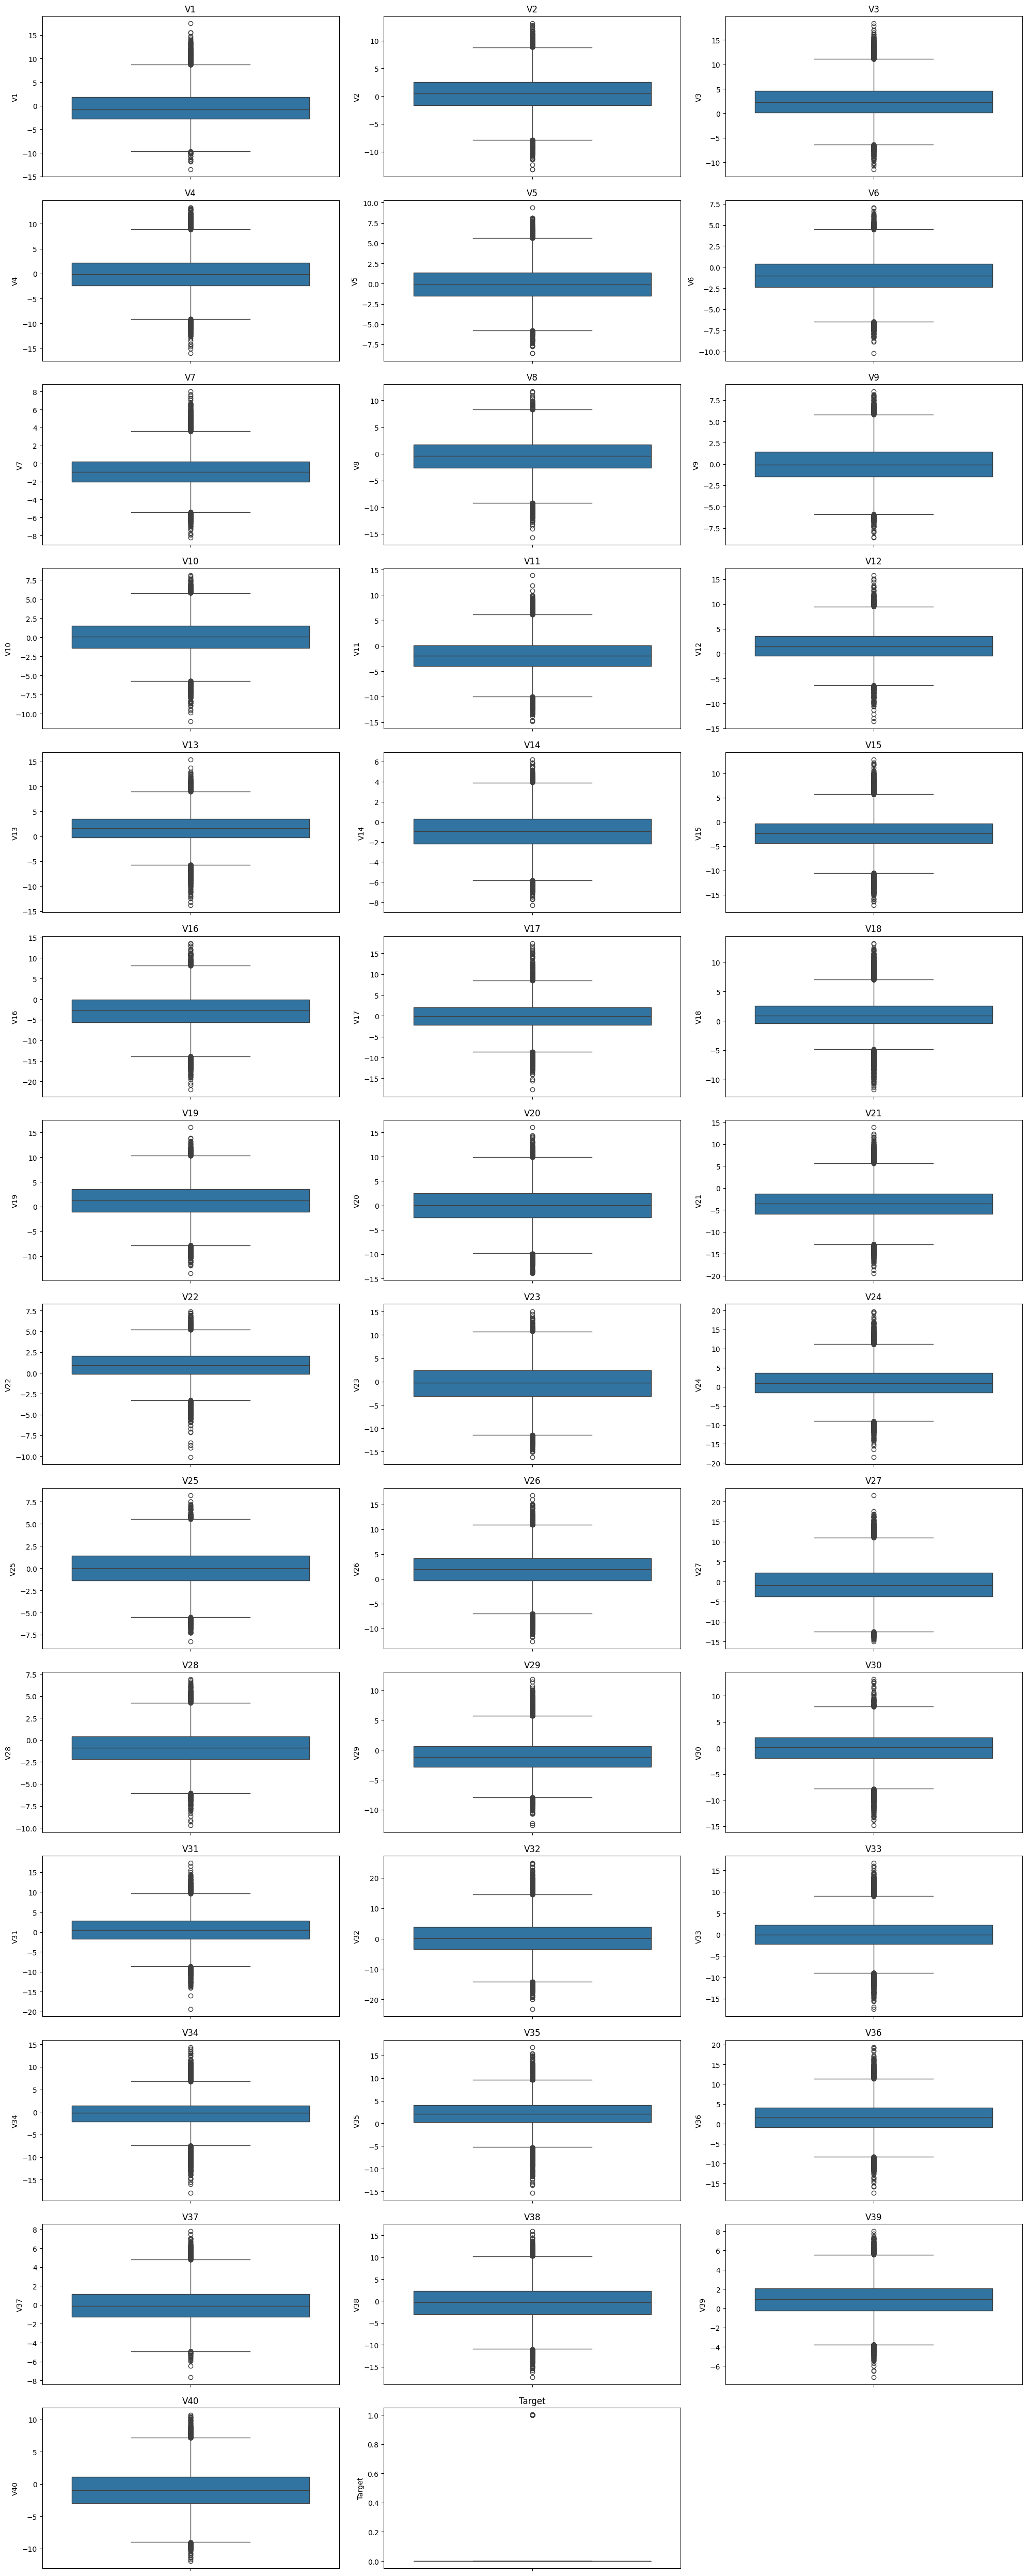

In [11]:
# Univariate Analysis 
cols = data.columns.tolist()
plt.figure(figsize=(20, 50))
for i, variable in enumerate(cols):
    plt.subplot(14, 3, i + 1)
    sns.boxplot(data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()


Both positive and negative outliers present and since we don't really know much about the attributes, the outliers will not be removed

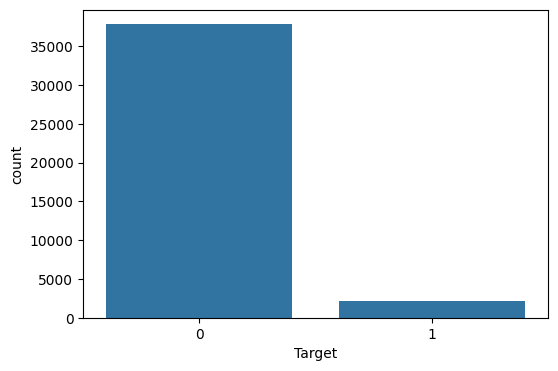

Target
0    37813
1     2187
Name: count, dtype: int64

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(data, x = 'Target')
plt.show()
data['Target'].value_counts()

Target is severly imbalanced with 94.5% of "No failures" and 5.5% of "Failures"

# Data Pre-processing

In [16]:
df =  data.copy()
x = df.drop('Target', axis = 1)
y = df['Target']

In [20]:
# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(28000, 40) (12000, 40) (28000,) (12000,)


In [25]:
y_train.value_counts(normalize=True)

Target
0   0.945
1   0.055
Name: proportion, dtype: float64

In [29]:
y_val.value_counts(normalize=True)

Target
0   0.945
1   0.055
Name: proportion, dtype: float64

# Fixing Missing Values 
We will fix the missing values in "V1" and "V2" using the median

In [30]:
imputer = SimpleImputer(strategy='median')
impute = imputer.fit(X_train)

X_train = impute.transform(X_train)
X_val = impute.transform(X_val)

# Model evaluation criterion
# 3 types of cost are associated with the provided problem
1. Replacement cost - False Negatives - Predicting no failure, while there will be a failure
2. Inspection cost - False Positives - Predicting failure, while there is no failure
3. Repair cost - True Positives - Predicting failure correctly
# How to reduce the overall cost?
We need to create a customized metric, that can help to bring down the overall cost
The cost associated with any model = (TPX15000) + (FPX5000) + (FNX40000)
And the minimum possible cost will be when, the model will be able to identify all failures, in that case, the cost will be (TP + FN)X15000
So, we will try to maximize Minimum cost/Cost associated with model

In [37]:
def model_performance_classification_sklearn(model, predictors, target):
    # Calculate True Positives, False Positives, and False Negatives
    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    
    # Calculate the cost associated with the model
    Cost = TP * 15 + FP * 5 + FN * 40
    
    # Calculate the minimum possible cost
    Min_cost = (TP + FN) * 15
    
    # Calculate the percentage of minimum cost compared to the model cost
    Percent = Min_cost / Cost * 100
    
    # Make predictions using the model
    pred = model.predict(predictors)
    
    # Calculate accuracy, recall, precision, and F1 score
    accuracy = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)
    
    # Create a dataframe to store the model performance metrics
    df_perf = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'Min_Cost Percentage': Percent}, index=[0])
    
    return df_perf

In [38]:
def confusion_matrix_sklearn(model, predictors, target):
    # Function to generate a confusion matrix using seaborn heatmap
    # Input: model - the trained classification model
    #        predictors - the input features for prediction
    #        target - the actual target values
    
    # Make predictions using the model
    y_pred = model.predict(predictors)
    
    # Generate the confusion matrix
    cm = confusion_matrix(target, y_pred)
    
    # Format the labels for the heatmap
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)
    
    # Create a heatmap using seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [39]:
# Define a function to calculate the ratio of minimum cost to model cost
def Min_vs_Model_Cost(y_train, y_pred):
    TP = confusion_matrix(y_train, y_pred)[1, 1]  # Calculate the number of true positives
    FP = confusion_matrix(y_train, y_pred)[0, 1]  # Calculate the number of false positives
    FN = confusion_matrix(y_train, y_pred)[1, 0]  # Calculate the number of false negatives
    
    return (TP + FN) * 15 / (TP * 15 + FP * 5 + FN * 40)  # Calculate the ratio of minimum cost to model cost

# Create a scorer using the Min_vs_Model_Cost function
scorer = metrics.make_scorer(Min_vs_Model_Cost, greater_is_better=True)

# Higher Values, represent a lower maintenance cost

In [40]:
models = []

models.append(("Logistic Regression", LogisticRegression(solver='newton-cg', random_state=42)))  # Logistic Regression model
models.append(("Decision Tree", DecisionTreeClassifier(random_state=42)))  # Decision Tree model
models.append(("Random Forest", RandomForestClassifier(random_state=42)))  # Random Forest model
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=42)))  # Gradient Boosting model
models.append(("AdaBoost", AdaBoostClassifier(random_state=42)))  # AdaBoost model
models.append(("Bagging", BaggingClassifier(random_state=42)))  # Bagging model
models.append(("XGBoost", XGBClassifier(random_state=42)))  # XGBoost model

results = []
names = []
score = []

print("\n" "Cross-validation performance metrics:" "\n")

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)  # Stratified K-Fold cross-validation
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scorer)  # Cross-validation score
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))  # Print the mean and standard deviation of the cross-validation score


Cross-validation performance metrics:

Logistic Regression: 0.521562 (0.009218)
Decision Tree: 0.650433 (0.005898)
Random Forest: 0.704496 (0.016068)
Gradient Boosting: 0.676777 (0.012569)
AdaBoost: 0.597757 (0.015718)
Bagging: 0.676891 (0.010466)
XGBoost: 0.768794 (0.007965)


In [41]:
print("\n" "Training performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = Min_vs_Model_Cost(y_train, model.predict(X_train))
    print("%s: %f" % (name, scores))


Training performance:

Logistic Regression: 0.521932
Decision Tree: 1.000000
Random Forest: 1.000000
Gradient Boosting: 0.734880
AdaBoost: 0.610528
Bagging: 0.914940
XGBoost: 1.000000


In [42]:
print("\n" "Validation performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = Min_vs_Model_Cost(y_val, model.predict(X_val))
    print("%s: %f" % (name, scores))


Validation performance:

Logistic Regression: 0.535219
Decision Tree: 0.651440
Random Forest: 0.733507
Gradient Boosting: 0.699609
AdaBoost: 0.605538
Bagging: 0.700107
XGBoost: 0.785942


The cross validation training performance scores are similar to the vaidation perfromance score. This indicates that the default algoroithms are able to generalize well.
Although some models tend to overfit the training set, as seen in the Descision tree, Random Forest and XGBoost

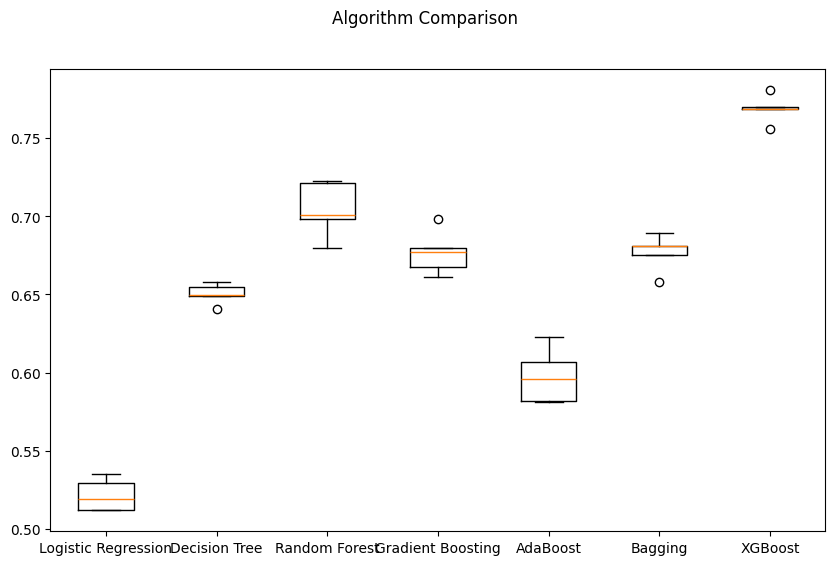

In [43]:
# plotting boxplots for CV scores of all models 
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Oversampling the training data

In [44]:
print("Counts of label '1' in y_train:", sum(y_train == 1))
print("Counts of label '0' in y_train:", sum(y_train == 0))

Counts of label '1' in y_train: 1531
Counts of label '0' in y_train: 26469


Oversampling using SMOTE

In [58]:
sm = SMOTE(sampling_strategy=1, random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [59]:
print("Counts of label '1' in y_train_smote:", sum(y_train_smote == 1))
print("Counts of label '0' in y_train_smote:", sum(y_train_smote == 0))

Counts of label '1' in y_train_smote: 26469
Counts of label '0' in y_train_smote: 26469


In [60]:
models_OS = []

models_OS.append(("Logistic Regression", LogisticRegression(solver='newton-cg', random_state=42)))  # Logistic Regression model
models_OS.append(("Decision Tree", DecisionTreeClassifier(random_state=42)))  # Decision Tree model
models_OS.append(("Random Forest", RandomForestClassifier(random_state=42)))  # Random Forest model
models_OS.append(("Gradient Boosting", GradientBoostingClassifier(random_state=42)))  # Gradient Boosting model
models_OS.append(("AdaBoost", AdaBoostClassifier(random_state=42)))  # AdaBoost model
models_OS.append(("Bagging", BaggingClassifier(random_state=42)))  # Bagging model
models_OS.append(("XGBoost", XGBClassifier(random_state=42)))  # XGBoost model

results = []
names = []
score = []

print("\n" "Cross-validation performance metrics:" "\n")

for name, model in models_OS:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)  # Stratified K-Fold cross-validation
    cv_results = cross_val_score(model, X_train_smote, y_train_smote, cv=kfold, scoring=scorer)  # Cross-validation score
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))  # Print the mean and standard deviation of the cross-validation score


Cross-validation performance metrics:

Logistic Regression: 0.789881 (0.005398)
Decision Tree: 0.938949 (0.003109)
Random Forest: 0.973788 (0.002560)
Gradient Boosting: 0.864861 (0.003134)
AdaBoost: 0.822712 (0.004164)
Bagging: 0.957957 (0.003201)
XGBoost: 0.976652 (0.004435)


In [61]:
print("\n" "Training performance:" "\n")

for name, model in models_OS:
    model.fit(X_train_smote, y_train_smote)
    scores = Min_vs_Model_Cost(y_train_smote, model.predict(X_train_smote))
    print("%s: %f" % (name, scores))


Training performance:

Logistic Regression: 0.789884
Decision Tree: 1.000000
Random Forest: 1.000000
Gradient Boosting: 0.866359
AdaBoost: 0.823289
Bagging: 0.997626
XGBoost: 0.998202


In [62]:
print("\n" "Validation performance:" "\n")

for name, model in models_OS:
    model.fit(X_train_smote, y_train_smote)
    scores = Min_vs_Model_Cost(y_val, model.predict(X_val))
    print("%s: %f" % (name, scores))


Validation performance:

Logistic Regression: 0.502939
Decision Tree: 0.657095
Random Forest: 0.818636
Gradient Boosting: 0.738185
AdaBoost: 0.580874
Bagging: 0.794830
XGBoost: 0.819658


The cross validation training performance scores are higher than the validation performance score. This tells us that the default algorithms trained on the oversampled dataset are not able to generalize well

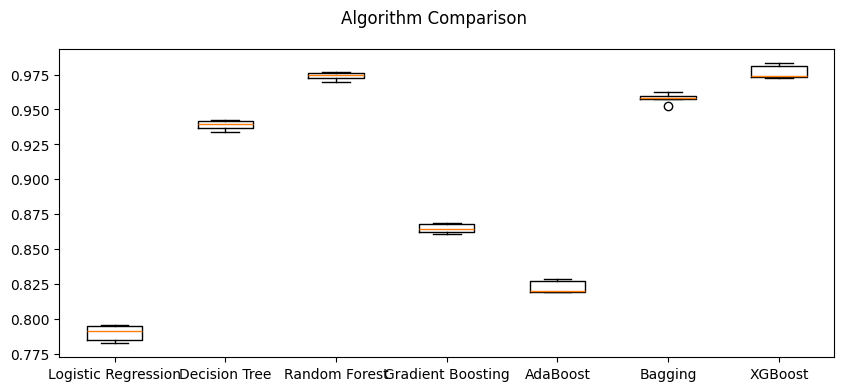

In [63]:
# plotting boxplots for CV scores of all models 
fig = plt.figure(figsize=(10, 4))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Undersampling the training data

In [64]:
# using random undersampling
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [65]:
print("Counts of label '1' in y_train_rus:", sum(y_train_rus == 1))
print("Counts of label '0' in y_train_rus:", sum(y_train_rus == 0))

Counts of label '1' in y_train_rus: 1531
Counts of label '0' in y_train_rus: 1531


In [66]:
models_RUS = []

models_RUS.append(("Logistic Regression", LogisticRegression(solver='newton-cg', random_state=42)))  # Logistic Regression model
models_RUS.append(("Decision Tree", DecisionTreeClassifier(random_state=42)))  # Decision Tree model
models_RUS.append(("Random Forest", RandomForestClassifier(random_state=42)))  # Random Forest model
models_RUS.append(("Gradient Boosting", GradientBoostingClassifier(random_state=42)))  # Gradient Boosting model
models_RUS.append(("AdaBoost", AdaBoostClassifier(random_state=42)))  # AdaBoost model
models_RUS.append(("Bagging", BaggingClassifier(random_state=42)))  # Bagging model
models_RUS.append(("XGBoost", XGBClassifier(random_state=42)))  # XGBoost model

results_rus = []
names_rus = []
score_rus = []

print("\n" "Cross-validation performance metrics:" "\n")

for name, model in models_RUS:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)  # Stratified K-Fold cross-validation
    cv_results = cross_val_score(model, X_train_rus, y_train_rus, cv=kfold, scoring=scorer)  # Cross-validation score
    results_rus.append(cv_results)
    names_rus.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))  # Print the mean and standard deviation of the cross-validation score


Cross-validation performance metrics:

Logistic Regression: 0.771656 (0.009609)
Decision Tree: 0.770998 (0.016894)
Random Forest: 0.844240 (0.018904)
Gradient Boosting: 0.829820 (0.016399)
AdaBoost: 0.787075 (0.007410)
Bagging: 0.811232 (0.012408)
XGBoost: 0.835772 (0.014250)


In [67]:
print("\n" "Training performance:" "\n")

for name, model in models_RUS:
    model.fit(X_train_rus, y_train_rus)
    scores = Min_vs_Model_Cost(y_train_rus, model.predict(X_train_rus))
    print("%s: %f" % (name, scores))


Training performance:

Logistic Regression: 0.773363
Decision Tree: 1.000000
Random Forest: 1.000000
Gradient Boosting: 0.879043
AdaBoost: 0.822234
Bagging: 0.982670
XGBoost: 1.000000


In [68]:
print("\n" "Validation performance:" "\n")

for name, model in models_RUS:
    model.fit(X_train_rus, y_train_rus)
    scores = Min_vs_Model_Cost(y_val, model.predict(X_val))
    print("%s: %f" % (name, scores))


Validation performance:

Logistic Regression: 0.489430
Decision Tree: 0.464809
Random Forest: 0.725664
Gradient Boosting: 0.652304
AdaBoost: 0.523822
Bagging: 0.679089
XGBoost: 0.732415


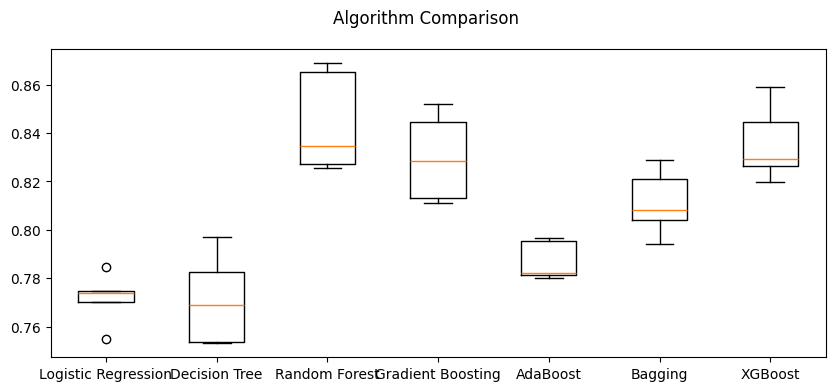

In [69]:
# plotting boxplots for CV scores of all models
fig = plt.figure(figsize=(10, 4))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_rus)
ax.set_xticklabels(names_rus)
plt.show()

# Model Selection
The models built on the original dataset have given a better generalized performance on cross validation training and validation sets unlinke models built on oversampled or undersampled set.
The mean cross validation scores on training sets are highest with XGBoost, Random Forest & Bagging Classifiers. We would further tune these models to increase performance

# Hyperparameter Tuning

In [75]:
model = XGBClassifier(random_state=42, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [0, 1, 2, 3, 4],
    'scale_pos_weight': [1, 2, 3, 4, 5]
}

scorer = metrics.make_scorer(Min_vs_Model_Cost, greater_is_better=True)

randomized_cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=3, scoring=scorer, n_jobs=-1, random_state=42)

randomized_cv.fit(X_train, y_train)

print("Best parameters:", randomized_cv.best_params_, randomized_cv.best_score_)

Best parameters: {'subsample': 0.9, 'scale_pos_weight': 5, 'reg_lambda': 0.4, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8} 0.7876890979815343


In [76]:
xg_tuned = XGBClassifier(random_state=42, eval_metric='logloss', **randomized_cv.best_params_)

xg_tuned.fit(X_train, y_train)

{'subsample': 0.9, 'scale_pos_weight': 5, 'reg_lambda': 0.4, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [78]:
# calculating different metrics on the training set
xgboost_tuned_train = model_performance_classification_sklearn(xg_tuned, X_train, y_train)
print('Traing performance:', xgboost_tuned_train)

Traing performance:    Accuracy  Recall  Precision    F1  Min_Cost Percentage
0     1.000   1.000      1.000 1.000              100.000


In [79]:
# calculating different metrics on the validation set
xgboost_tuned_val = model_performance_classification_sklearn(xg_tuned, X_val, y_val)
print('Validation performance:', xgboost_tuned_val)

Validation performance:    Accuracy  Recall  Precision    F1  Min_Cost Percentage
0     0.991   0.861      0.979 0.916               80.821


1. The best hyperparameters using RandomizedSearch CV for XGBoost model were found to be: 'subsample': 0.9, 'scale_pos_weight': 5, 'reg_lambda': 0.4, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8

2. The average cross validation training performance score (customized metric) using the best parameter XGBoost model is 0.80. This is similar to the performance score (customized metric) on the validation set i.e., 0.82. This indicates the model may generalize with a performance score of ~0.80-0.82

3. The model does however have a tendency to overfit the training set as can be observed from training performance (customized metric score of 1.0)

In [80]:
# Random forest hyperparameter tuning
model = RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': [0.6, 0.7, 0.8, 0.9, 1],
    'class_weight': ['balanced', 'balanced_subsample']
}

scorer = metrics.make_scorer(Min_vs_Model_Cost, greater_is_better=True)

randomized_cv2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, scoring=scorer, n_jobs=-1, random_state=42)

randomized_cv2.fit(X_train, y_train)

print("Best parameters:", randomized_cv2.best_params_, randomized_cv2.best_score_)

Best parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6, 'max_features': 'log2', 'max_depth': 7, 'class_weight': 'balanced'} 0.747157481633894


In [81]:
rf_tuned = RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True, **randomized_cv2.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7,
                       max_features='log2', max_samples=0.6, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=200, oob_score=True,
                       random_state=42)

In [82]:
# calculating different metrics on the training set
rf_tuned_train = model_performance_classification_sklearn(rf_tuned, X_train, y_train)
print('Traing performance:', rf_tuned_train)

Traing performance:    Accuracy  Recall  Precision    F1  Min_Cost Percentage
0     0.982   0.887      0.807 0.845               79.436


In [84]:
# calculating different metrics on the validation set
rf_tuned_val = model_performance_classification_sklearn(rf_tuned, X_val, y_val)
print('Validation performance:', rf_tuned_val)

Validation performance:    Accuracy  Recall  Precision    F1  Min_Cost Percentage
0     0.981   0.858      0.807 0.832               76.636


The best hyperparameters using RandomizedSearch CV for Random forest model were found to be: 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6, 'max_features': 'log2', 'max_depth': 7, 'class_weight': 'balanced'
The average 5 fold cross validation training performance score (customized metric) using the best parameter Random forest model is 0.747. This is similar to the performance score (customized metric) on the validation set i.e., 0.766. This indicates the model may generalize with a performance score of ~0.77

In [86]:
# bagging classifier hyperparameter tuning 
model = BaggingClassifier(random_state=42)
param_grid = {
    "max_samples": [0.8, 0.9],
    "max_features": [0.8, 0.9],
    "n_estimators": [40, 50],
}

scorer = metrics.make_scorer(Min_vs_Model_Cost, greater_is_better=True)

randomized_cv3 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, scoring=scorer, n_jobs=-1, random_state=42)

randomized_cv3.fit(X_train, y_train)

print("Best parameters:", randomized_cv3.best_params_, randomized_cv3.best_score_)

Best parameters: {'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.8} 0.7046349438683481


In [88]:
# training the model with the best parameters
bagging_tuned = BaggingClassifier(random_state=42, **randomized_cv3.best_params_)
bagging_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=50,
                  random_state=42)

In [89]:
# calculating different metrics on the training set
bagging_tuned_train = model_performance_classification_sklearn(bagging_tuned, X_train, y_train)
print('Traing performance:', bagging_tuned_train)

Traing performance:    Accuracy  Recall  Precision    F1  Min_Cost Percentage
0     1.000   0.992      1.000 0.996               98.605


In [90]:
# calculating different metrics on the validation set
bagging_tuned_val = model_performance_classification_sklearn(bagging_tuned, X_val, y_val)
print('Validation performance:', bagging_tuned_val)

Validation performance:    Accuracy  Recall  Precision    F1  Min_Cost Percentage
0     0.987   0.788      0.970 0.870               73.460


The best hyperparameters using RandomizedSearch CV for Bagging Classifier were found to be: n_estimator 50, max_samples 0.8, max_features 0.8

The average 5 fold cross validation training performance score (customized metric) using the best parameter Bagging classifier is 0.70. This is similar to the performance score (customized metric) on the validation set i.e., 0.73. This indicates the model may generalize with a performance score of ~0.70-0.73

The model does however have a tendency to overfit the training set as can be observed from training performance (customized metric score of 0.986)

# Model Performance Comparison

In [93]:
# training performance comparison
models_train_comp = pd.concat([xgboost_tuned_train.T, rf_tuned_train.T, bagging_tuned_train.T], axis=1)

models_train_comp.columns = ['XGBoost', 'Random Forest', 'Bagging']
print('Training performance comparison:' '\n', models_train_comp)

Training performance comparison:
                      XGBoost  Random Forest  Bagging
Accuracy               1.000          0.982    1.000
Recall                 1.000          0.887    0.992
Precision              1.000          0.807    1.000
F1                     1.000          0.845    0.996
Min_Cost Percentage  100.000         79.436   98.605


In [94]:
# training performance comparison   
models_val_comp = pd.concat([xgboost_tuned_val.T, rf_tuned_val.T, bagging_tuned_val.T], axis=1)

models_val_comp.columns = ['XGBoost', 'Random Forest', 'Bagging']
print('Validation performance comparison:' '\n', models_val_comp)

Validation performance comparison:
                      XGBoost  Random Forest  Bagging
Accuracy               0.991          0.981    0.987
Recall                 0.861          0.858    0.788
Precision              0.979          0.807    0.970
F1                     0.916          0.832    0.870
Min_Cost Percentage   80.821         76.636   73.460


The XGBoost Tuned model with Random Search is giving the highest performance score (Minimum_Vs_Model_cost) of 0.80 on the Validation Set. Although this algorithm is giving much higher performance on training set (1.0) indicating overfitting, we still observe the following -

The average cross validation Training performance score (Minimum_Vs_Model_cost) with this model is 0.80, similar to the validation score of 0.80
The accuracy, precision and F1 scores of the training & validation models are very much comparable

We will choose this tuned model to see if it can generalize well on the testing dataset to give a likewise high performance score (Minimum_Vs_Model_cost) ~ 0.8

# Test set final performance

In [95]:
# Loading the dataset 
test = pd.read_csv('test.csv')

In [96]:
X_test = test.drop(['Target'], axis=1)
y_test = test['Target']

In [97]:
y_test.value_counts(normalize=True)

Target
0   0.945
1   0.055
Name: proportion, dtype: float64

In [98]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      9989 non-null   float64
 1   V2      9993 non-null   float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 non-null  float64
 16  V17     10000 non-null  float64
 17  V18     10000 non-null  float64
 18  V19     10000 non-null  float64
 19  V20     10000 non-null  float64
 20  V21     10000 non-null  float64
 21  V22     10000 non-null  float64
 22 

# Fix the missing values for attributes "V1" and "V2"

In [99]:
imputer = SimpleImputer(strategy='median')
impute = imputer.fit(X_test)
X_test = imputer.transform(X_test)

In [100]:
print("Test performance:" "\n") 

final_model = XGBClassifier(random_state=42, eval_metric='logloss', **randomized_cv.best_params_)

name = 'XGBoost'

final_model.fit(X_train, y_train)
final_scores = Min_vs_Model_Cost(y_test, final_model.predict(X_test))
print("%s: %f" % (name, final_scores))

Test performance:

XGBoost: 0.788184


In [101]:
xgboost_test = model_performance_classification_sklearn(final_model, X_test, y_test)
print(xgboost_test)

   Accuracy  Recall  Precision    F1  Min_Cost Percentage
0     0.990   0.843      0.977 0.905               78.818


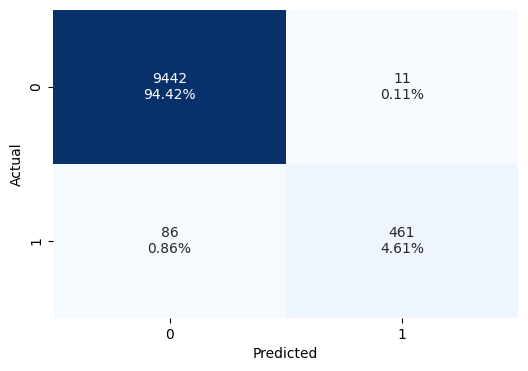

In [102]:
# Confusion matrix for the final model
confusion_matrix_sklearn(final_model, X_test, y_test)

The XGBoost tuned model is generalizing well on the test data with a Minimum_Vs_Model_cost of 0.788 (the cross validation training average score was 0.788 and the validation score was 0.802)

The model is able to make predictions resulting in a maintenance cost ~ (1/0.788 or ~1.27) times the minimum maintenance cost possible

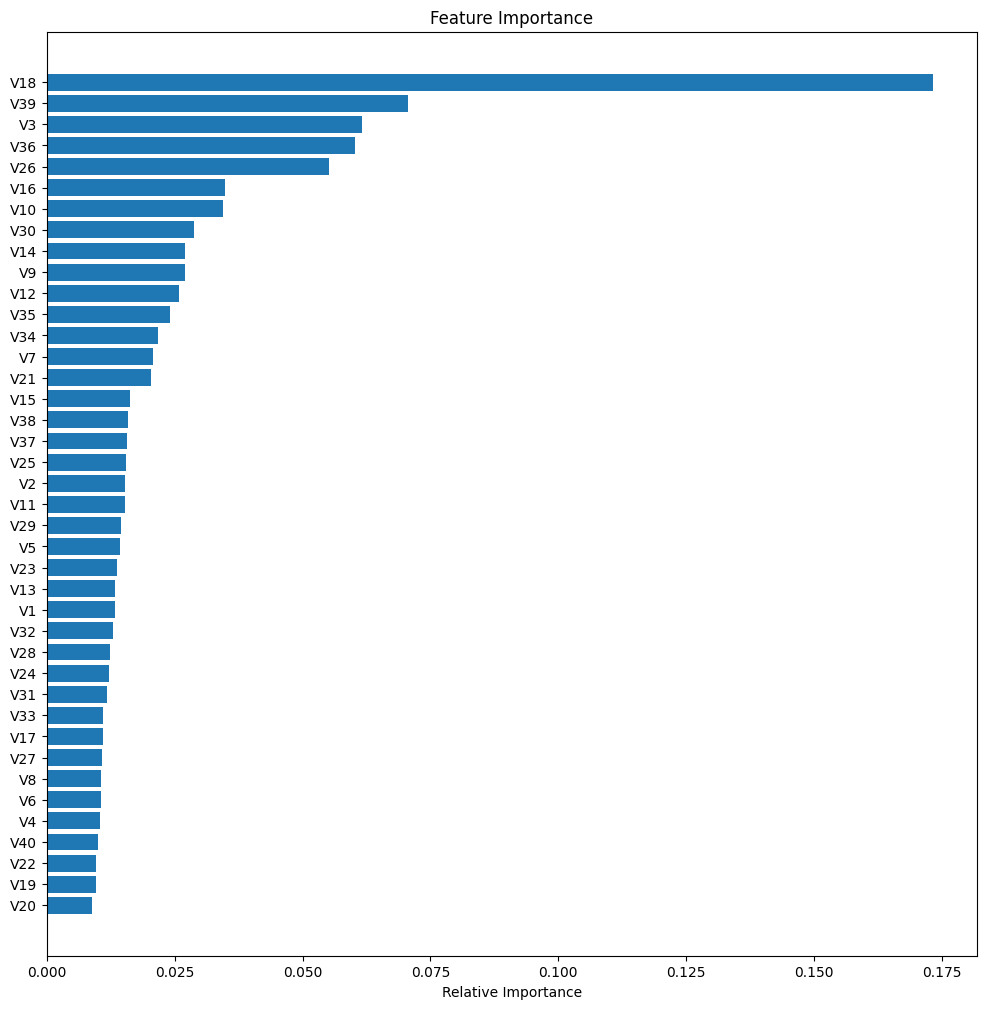

In [103]:
# features with the most importance
feature_names = data.columns
feature_importance = final_model.feature_importances_
indices = np.argsort(feature_importance)

plt.figure(figsize=(12, 12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), feature_importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The top attributes which have the maximum importance for making accurate failure/ no-failure predictions are "V18", "V39", "V26", "V3" & "V10"

# Pipelines to build the final model
Pipelines can be used to put the final model in production

In [104]:
X_train_pipeline = train.drop(['Target'], axis=1)
y_train_pipeline = train['Target']

In [105]:
X_test_pipeline = test.drop(['Target'], axis=1)
y_test_pipeline = test['Target']

In [106]:
model_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('model', XGBClassifier(random_state=42, eval_metric='logloss', **randomized_cv.best_params_))
])

model_pipeline.fit(X_train_pipeline, y_train_pipeline)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=250,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [107]:
model_pipeline.predict(X_test_pipeline)

array([0, 0, 0, ..., 0, 0, 0])

In [108]:
min_cost = Min_vs_Model_Cost(y_test_pipeline, model_pipeline.predict(X_test_pipeline))

In [109]:
print('Minimum cost:', min_cost)

Minimum cost: 0.8000975134080937


The pipeline performance is as expected (Minimum_Vs_Model_cost 0.800) indicating it was built accurately to replicate the final chosen model after necessary pre processing

# Business Insights and Conclusions
A machine learning model has been built to minimize the total maintenance cost of machinery/processes used for wind energy production

The final tuned model (XGBoost) was chosen after building ~7 different machine learning algorithms & further optimizing for target class imbalance (having few "failures" and many "no failures" in dataset) as well as finetuning the algorithm performance (hyperparameter and cross validation techniques)

A pipeline was additionally built to productionise the final chosen model

The model is expected to generalize well in terms of predictions & expected to result in a maintenance cost ~1.27 times minimum possible maintenance cost. Having no model in place for predictions could potentially result in costs as high as ~2.67 minimum possible maintenance cost. Hence, productionising the model has a large cost saving advantage

The main attributes of importance for predicting failures vs. no failures were found to be "V18", "V39", "V26", "V3" & "V10" in order of decreasing importance. This added knowledge can be used to refine the process of collecting more frequent sensor information to be used in improving the machine learning model to further decrease maintenance costs